In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision import transforms
from torchvision.models import VGG16_Weights
from torch.optim.lr_scheduler import StepLR
import time
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
import os
from os import path
import datetime

In [2]:
print(torch.cuda.is_available())
print(torch.__version__)

False
2.0.1


In [3]:
input_dataset = '28_11_2023_21_51_55'

In [4]:
def dataset_path(timestamp: str):
    abs_path = os.getcwd()
    two_up =  path.abspath(path.join(abs_path ,"../.."))
    return path.join(two_up, 'data', f'{os.path.basename(abs_path)}', timestamp)

In [5]:
dataset_path(input_dataset)

'C:\\Users\\ilona\\OneDrive\\Dokumente\\MCI\\DiBSe\\DiBSE-Sem5\\GesamtProjekt\\TT_git\\tensionterminator\\data\\bodyside_finder\\28_11_2023_21_51_55'

In [6]:
transforms_wt = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

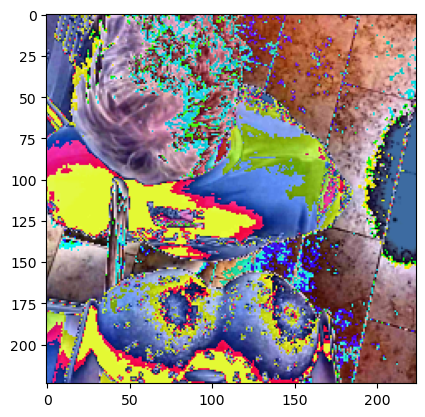

In [7]:
orig_set = datasets.ImageFolder(
    root=dataset_path(input_dataset),
    transform=transforms_wt
)
data, label = orig_set[100]
transform_test = T.ToPILImage()
plt.imshow(transform_test(data))


In [8]:
orig_set.classes

['left', 'middle', 'right']

In [9]:
len(orig_set)

10163

In [10]:
data, label = orig_set[0]
print(data.size())

torch.Size([3, 224, 224])


In [11]:
import torch
from torch.utils.data import random_split, DataLoader

data_loader = DataLoader(orig_set, batch_size=len(orig_set), shuffle=True)

# Define the dataset size
dataset_size = len(orig_set)

# Calculate the sizes for training, validation, and test sets
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into training, validation, and test sets
train_set, val_set, test_set = random_split(orig_set, [train_size, val_size, test_size])

In [12]:
val_data, val_label = val_set[1]
print(val_data.size())

torch.Size([3, 224, 224])


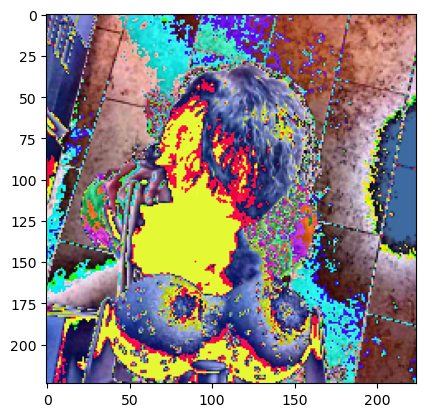

In [13]:
transform = T.ToPILImage()
plt.imshow(transform(val_data))

In [14]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=8,
    shuffle=True,
    num_workers=8
)

In [15]:
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=8,
    shuffle=True,
    num_workers=8
)

In [16]:
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=8,
    shuffle=True,
    num_workers=8
)

In [17]:
model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

#print(model.fc)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)
print(model.fc)

In [18]:
# Modify the classifier (fully connected) layers for your specific classification task
num_features = model.classifier[6].in_features

# Define the new classifier
classifier = nn.Sequential(
    nn.Linear(num_features, 2048),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(2048,1024),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(1024,500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500,3)
)

# Replace the existing classifier
model.classifier[6] = classifier

#print(model.fc)

In [19]:
#print(model)

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

In [21]:
#execute next
import os
from os import path
import sys
sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), '../..'))

from framework.framework import FrameworkLogger
from framework.main_func import main_train_func

input_args = [train_loader, val_loader, model, criterion, optimizer, exp_lr_scheduler, device]

# Modell trainieren
logger = FrameworkLogger(5, model, main_train_func, input_args, "bodyside_VGG16_Weights.IMAGENET1K_V1_8kern")
logger.train_model_pyt()
#logger.generate_statistics()

Epoch 0


KeyboardInterrupt: 

start_time = time.time()

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)/inputs.size(0)


    exp_lr_scheduler.step()
    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = running_corrects / len(train_loader)

    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in (val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() / inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_corrects.double() / len(val_loader)
    print(f"Epoch: {epoch}: Train: Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f} Val: Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

end_time = time.time()
print("Time:", end_time - start_time)

In [ ]:
def get_time():
    return datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")

In [ ]:
def model_save_path(timestamp: str):
    abs_path = os.getcwd()
    two_up =  path.abspath(path.join(abs_path ,"../.."))
    return path.join(two_up, 'models', f'{os.path.basename(abs_path)}', timestamp, f'model_{get_time()}.pt')

In [ ]:
model_save_path(input_dataset)

In [ ]:
save_path = model_save_path(input_dataset)

os.makedirs(os.path.dirname(save_path), exist_ok=True)

torch.save(model.state_dict(), save_path)

test_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=4,
    shuffle=True,
    num_workers=16
)

In [ ]:
num_correct = 0.0
for inputs, labels in test_loader:
    model.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)
    predict_label = model(inputs)
    _, predicted = torch.max(predict_label,1)
    num_correct += (predicted == labels).float().sum()

    accuracy = num_correct/(len(test_loader)*test_loader.batch_size)

print(len(test_loader), test_loader.batch_size)
print("Test Accuracy: {}".format(accuracy))

In [ ]:
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()

def print_grid():
    inputs, classes = next(iter(test_loader))
    out = torchvision.utils.make_grid(inputs)
    class_names = orig_set.classes

    outputs = model(inputs.to(device))
    _, preds = torch.max(outputs, 1)

    imshow(out, title=[class_names[x] for x in preds])

print_grid()

In [ ]:
#starttime 09:57
#endtime
from datetime import datetime

# Get the current timestamp
timestamp = datetime.now()
formatted_timestamp = timestamp.strftime("%Y-%m-%d %H:%M:%S")
print("Formatted timestamp:", formatted_timestamp)

In [23]:
logger.generate_statistics()